In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from torch.optim import Adam
from torch import nn
from sklearn.metrics import accuracy_score

In [3]:
class BayesianLogReg(nn.Module):
    
    def __init__(self, features_num = 784, classes_num=10, samples_num=1):
        super(BayesianLogReg, self).__init__()
        self.features_num = features_num
        self.classes_num = classes_num
        self.mu = nn.Parameter(torch.randn(features_num*classes_num))
        self.sigma = nn.Parameter(torch.abs(torch.randn(features_num*classes_num)))
        self.standart_normal = torch.distributions.MultivariateNormal(
            loc = torch.zeros_like(self.mu), 
            precision_matrix=torch.eye(self.mu.shape[0]))
        self.samples_num = samples_num
    def forward(self, x):
        w_est = torch.zeros(self.features_num, self.classes_num)
        for i in range(self.samples_num):
            z = self.standart_normal.sample()
            w = torch.diag(self.sigma) @ z  + self.mu
            w = w.view(self.features_num, self.classes_num)
            w_est += w
        return x @ w_est
    
    def infer(self, x):
        return x @ self.mu.view(self.features_num, self.classes_num)
    
    def masked_infer(self, x, mask):
        w = mask * self.mu
        return x @ w.view(self.features_num, self.classes_num)

In [4]:
from torch.utils.data import TensorDataset, DataLoader

In [28]:
def get_loader(data, batch_size=128):
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=8)
    return data_loader

def train_epoch(model, optimizer, train_loader, criterion):
    model.train()
    k = 0
    for X, y in train_loader:
        k += 1
        out = model(X)
        loss = criterion(out, y, model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if k%100 == 0:
            print('On {}th batch loss is {}'.format(k, loss.detach().numpy()))
    return 

def evaluate_loss(loader, model, criterion):
    with torch.no_grad():
        model.eval()
        loss = 0
        k = 0
        for X, y in loader:
            k += 1
            out = model(X)
            loss += criterion(out, y, model).cpu().numpy() 
        loss /= k + 1
    return loss

def evaluate_accuracy(loader, model, mask=None):
    predictions = []
    labels = []
    with torch.no_grad():
        model.eval()
        for X, y in loader:
            if mask is not None:
                out = model.masked_infer(X, mask)
            else:
                out = model.infer(X)
            labels.append(y)
            predictions.append(torch.argmax(out, dim=-1)) 
        labels = torch.cat(labels).numpy()
        predictions = torch.cat(predictions).numpy()
    return labels, predictions

def train(model, opt, train_loader, test_loader, criterion, n_epochs, verbose=True, device='cpu'):
    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion)
        train_loss = evaluate_loss(train_loader, model, criterion)
        val_loss = evaluate_loss(test_loader, model, criterion)
        if verbose:
             print(('Epoch [%d/%d], Loss (train/test): %.6f/%.6f,')
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss))
    return

In [29]:
from torchvision.datasets import MNIST
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

In [12]:
model = BayesianLogReg(samples_num=1)

In [30]:
optimizer = Adam(model.parameters(), lr=1e-3)

In [31]:
crossentropy = nn.CrossEntropyLoss(reduction='sum')
def elbo(out, y, model):
    cross = crossentropy(out, y)
    # 
    kl = 0.5 * (torch.sum(model.sigma) + torch.dot(model.mu, model.mu) - torch.sum(torch.log(model.sigma)))
    return cross + kl

In [32]:
train_loader = get_loader(train_data, batch_size=64)
valid_loader  = get_loader(test_data, batch_size=64)

In [33]:
train(model, optimizer, train_loader, valid_loader, elbo, 1)

On 100th batch loss is 4230.017578125
On 200th batch loss is 4393.67138671875
On 300th batch loss is 4250.4189453125
On 400th batch loss is 4252.8955078125
On 500th batch loss is 4359.22705078125
On 600th batch loss is 4352.44970703125
On 700th batch loss is 4267.53662109375
On 800th batch loss is 4235.97900390625
On 900th batch loss is 4304.10595703125
Epoch [1/1], Loss (train/test): 4288.457540/4254.331200,


In [34]:
true, pred = evaluate_accuracy(valid_loader, model)
print(accuracy_score(true, pred))

0.8763


In [35]:
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm
prune = lambda percentage, lamb: lamb < np.percentile(lamb, percentage)

In [36]:
lamb = torch.exp(- model.mu**2 / 2*model.sigma**2).detach().numpy()

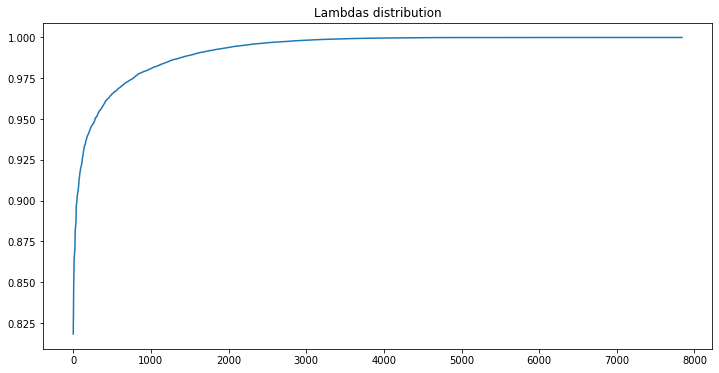

In [37]:
fig = plt.figure(figsize=(12,6)) 
plt.plot(sorted(lamb))
_ = plt.title('Lambdas distribution')

In [38]:
model_copy = deepcopy(model)
model.mu = model_copy.mu
model.sigma = model_copy.sigma

In [39]:
def conduct_pruning_experiment(model):
    lamb = torch.exp(- model.mu**2 / 2*model.sigma**2).detach().numpy()
    accuracies_bayesian = []
    accuracies_random = []
    order = np.random.permutation(model.mu.shape[0])
    x = np.arange(0,100)
    for perc in tqdm(x[::-1]):

        mask_bayesian = torch.FloatTensor(prune(perc, lamb))

        to = np.percentile(np.arange(model.mu.shape[0]), perc).astype(int)
        mask_random = torch.zeros(model.mu.shape[0])
        mask_random[[order[:to]]] = 1

        true, pred = evaluate_accuracy(valid_loader, model, mask_bayesian)
        accuracies_bayesian.append(accuracy_score(true, pred))

        true, pred = evaluate_accuracy(valid_loader, model, mask_random)
        accuracies_random.append(accuracy_score(true, pred))
    return x, accuracies_random, accuracies_bayesian

In [40]:
x, accuracies_random, accuracies_bayesian = conduct_pruning_experiment(model)

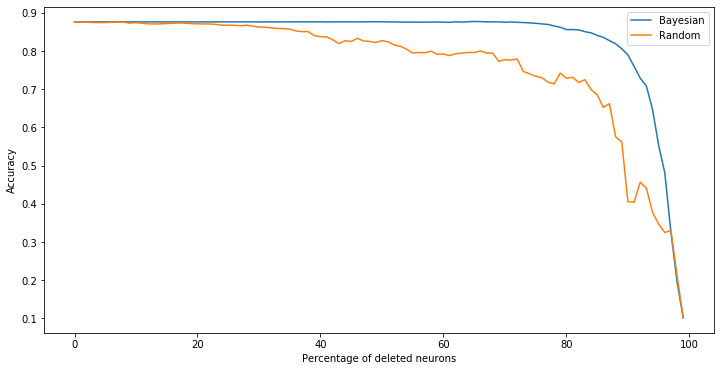

In [41]:
fig = plt.figure(figsize=(12,6)) 
plt.plot(x, accuracies_bayesian, label = 'Bayesian')
plt.plot(x, accuracies_random, label = 'Random')
plt.xlabel('Percentage of deleted neurons')
plt.ylabel('Accuracy')
# plt.xlim(99, 1)
_=plt.legend()